In [2]:
source("helper.R")
library(lubridate)
max_expid<-get_max("Log")+1
dataset_name="China"

family_name="stochvol"
model_name="matern"
exp_name<-glue("Pricing_{dataset_name}_Model_{family_name}_{model_name}")
log_dir<-glue("Log/{max_expid}.{exp_name}")
logger=get_logger(log_dir, log_name = "log", debug = TRUE)
futile.logger::flog.info("start experiment", name = "log")

## get logger

seed_random<-123
n=30
risk_free_rate<-0.02

future_days_needed_for_pricing<-31
futile.logger::flog.info(glue("risk-free rate: {risk_free_rate}"), name = "log")
set.seed(seed_random)

futile.logger::flog.info(glue("use seed: {seed_random}"), name = "log")

futile.logger::flog.info(glue("number of experiments: {n}"), name = "log")
if (dataset_name=="China"){
dataset <- load_data("data/IFclose.csv")

}else if (dataset_name=="Saudi"){
dataset <- load_data("data/1180_vol.csv")

}else if (dataset_name=="SPY"){

dataset <- load_data("data/SPY.csv")

}else{

    stop("Error: Invalid data set")
}

last_date <- max(dataset$date)
all_days <- seq.Date(from = last_date + 1, by = "day", length.out = future_days_needed_for_pricing)
biz_days <- all_days[!weekdays(all_days) %in% c("Saturday", "Sunday")]
index<-seq_len(future_days_needed_for_pricing)[!weekdays(all_days) %in% c("Saturday", "Sunday")]



INFO [2025-09-10 21:40:25] start experiment
INFO [2025-09-10 21:40:25] risk-free rate: 0.02


INFO [2025-09-10 21:40:25] use seed: 123
INFO [2025-09-10 21:40:25] number of experiments: 30


Rows: 1595 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): ins_id
dbl  (1): close
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
new_data <- data.frame(
  logreturn = NA,
  times = max(dataset$times) + index,
  date = biz_days,
  close = NA
)

dataset <- rbind(dataset, new_data)

In [4]:


## best fit stochvol IF,2/137.3123/0.5628
## best fit stochvol SR,4/118.271/0.7802



best.rspde.order<-2
best.prior.range.nominal<-137.3123
best.prior.std.dev.nominal<-0.5628









## best fit IF,2/137.3123/0.5628

In [5]:
if (model_name=="matern"){
latent_model <- rspde.matern(
    mesh = fm_mesh_1d(dataset$times),
    parameterization = "matern",
    rspde.order = best.rspde.order,
    prior.range.nominal = best.prior.range.nominal,
    prior.std.dev.nominal = best.prior.std.dev.nominal
  )
    
    formula_latent <- logreturn ~ -1 + Intercept(1)+ field(times, model = latent_model)
}
    
fit<-bru(formula_latent, family=family_name, data = dataset)
result_fit<- rspde.result(fit, "field", latent_model, parameterization="matern")
summary(result_fit)

,mean,sd,0.025quant,0.5quant,0.975quant,mode
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
std.dev,0.0233999,0.00279145,0.018078,0.0233781,0.0289883,0.0234997
range,0.2708880,0.02418890,0.220685,0.2724910,0.3140090,0.2800980
nu,0.4731670,0.04467370,0.379324,0.4765130,0.5518060,0.4913450


In [7]:
new_data <- dataset[is.na(dataset$logreturn), ]

In [8]:
discount_factor<- (1+risk_free_rate)**(-dim(new_data)[1]/252)

In [9]:
delta_S_T<-generate(fit, new_data, ~ exp((field+Intercept)/2), n.samples = 100000)

In [12]:


if(family_name=="stochvol.t"){
  dof <- fit$summary.hyperpar$mean[1]
  random_return_rate<-simulate_T(dof,delta_S_T)
}else if (family_name=="stochvol"){
  random_return_rate<-matrix(
        rnorm(length(delta_S_T),0,1),
        nrow = nrow(delta_S_T),
        ncol = ncol(delta_S_T)
    )
}

In [13]:
the_index_of_last_day<-sum(!is.na(dataset$logreturn))

In [14]:
return_rate_to_end<-exp(colSums(random_return_rate))
simulated_final_prices <- dataset$close[the_index_of_last_day]* return_rate_to_end

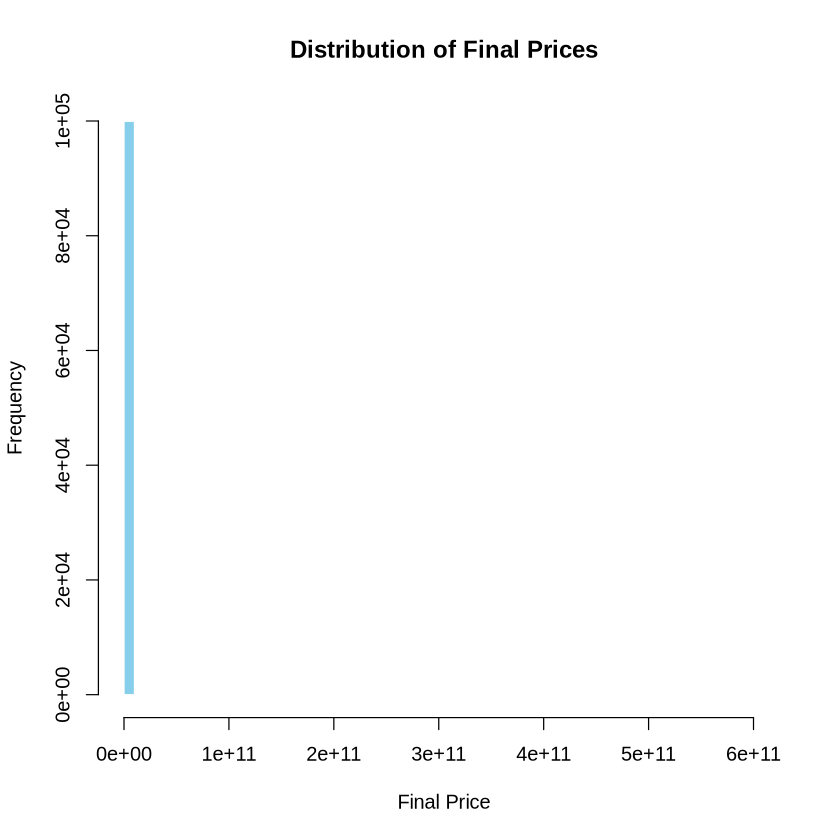

In [15]:
par(bg = "white")
hist(simulated_final_prices, 
     breaks = 50, col = "skyblue", border = "white",
     main = "Distribution of Final Prices", xlab = "Final Price")

In [ ]:
pricing_values<-list()



call_records<-as.data.frame(read_csv("data/calls_records.csv"))
put_records<-as.data.frame(read_csv("data/put_records.csv"))



for (i in 1:nrow(call_records)){
    strike<-call_records$strike[i]
    call_price<-expected_payoff_for_European_option(simulated_final_prices, K = strike, type = "call", discount_factor = discount_factor)
    pricing_values$call_records[i]<-call_price
}

for (i in 1:nrow(put_records)){
    strike<-put_records$strike[i]
    put_price<-expected_payoff_for_European_option(simulated_final_prices, K = strike, type = "put", discount_factor = discount_factor)
    pricing_values$put_records[i]<-put_price
}


call_records$theoretical_price<-pricing_values$call_records
put_records$theoretical_price<-pricing_values$put_records



write.csv(call_records, glue("{log_dir}/calls_records_with_theoretical_price.csv"))
write.csv(put_records, glue("{log_dir}/put_records_with_theoretical_price.csv"))






Rows: 20 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): price, strike



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 20 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): price, strike

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [44]:
find_market_col <- function(df) {
  cand <- c("market_price", "price", "close", "mid")
  hit <- cand[cand %in% names(df)]
  if (length(hit) == 0) stop("未找到市场价格列，请在 cand 中加入正确列名。已有列：", paste(names(df), collapse=", "))
  hit[1]
}
plot_prices <- function(df, title = "Calls", xlab = "Strike", ylab = "Price", underlying = NULL) {
  # 选择市场价格列
  mcol <- find_market_col(df)

  # 仅保留需要列并去 NA
  keep <- c("strike", mcol, "theoretical_price")
  df2 <- df[keep]
  df2 <- df2[complete.cases(df2), ]

  # 按 strike 排序
  ord <- order(df2$strike)
  x  <- df2$strike[ord]
  yM <- df2[[mcol]][ord]              # 市场价格
  yT <- df2$theoretical_price[ord]    # 理论价格

  # 确定坐标范围
  yr <- range(c(yM, yT), finite = TRUE)

  # 画图（白底）
  par(bg = "white")
  plot(x, yM, type = "l", lwd = 2,
       col = rgb(0,0,1,0.6),             # 半透明蓝色
       xlab = xlab, ylab = ylab,
       main = title, ylim = yr, cex.axis=1.2, cex.lab=1.2, cex.main=1.3)
  lines(x, yT, lwd = 2, lty = 2,
        col = rgb(1,0,0,0.6))            # 半透明红色

  # 如果提供了 underlying，就画一条竖线
  if (!is.null(underlying)) {
    abline(v = underlying, col = "black", lty = 3, lwd = 2)
  }

  legend("topleft",
         legend = c("Market", "Theoretical", if (!is.null(underlying)) "Underlying" else NULL),
         lwd = c(2, 2, if (!is.null(underlying)) 2 else NULL),
         lty = c(1, 2, if (!is.null(underlying)) 3 else NULL),
         col = c(rgb(0,0,1,0.6), rgb(1,0,0,0.6), if (!is.null(underlying)) "black" else NULL),
         bty = "n")
}


# --- 分两幅图显示：左边 Call，右边 Put ---
png(glue( "{log_dir}/calls_puts.png"), width=2000, height=1000, res=200)  # 像素宽高
op <- par(mfrow = c(1, 2), mar = c(4, 4, 3, 1), cex=1.2)
plot_prices(call_records, title = "Call: Market vs Theoretical", xlab = "Strike", ylab = "Price",underlying=dataset$close[the_index_of_last_day])
plot_prices(put_records,  title = "Put: Market vs Theoretical",  xlab = "Strike", ylab = "Price",underlying=dataset$close[the_index_of_last_day])
par(op)
dev.off()

agg_record_140303005 
                   2